In [2]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import math
from matplotlib import pyplot as plt
import os


imageSize = 48
timestep = 1000
maxEpoch = 500
batchSize = 200
device = "cuda:1" if torch.cuda.is_available() else "cpu"

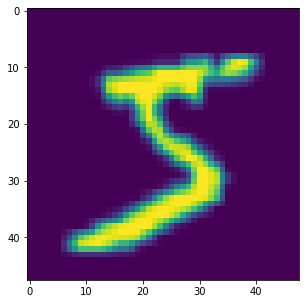

In [3]:
### Convert the image into tensor and scale the data from 0-255 to [0-1]. 
## Change image dimension order from (height,width,channel) to (channel,height,width).
pilToTensor = transforms.Compose([
    transforms.Resize((imageSize, imageSize)),
    transforms.ToTensor()
])

### Scales tensor from [0.0, 1.0] back to [0, 255]
### Casts tensor from float back to uint8 then to PIL
tensorToPil = transforms.Compose([
    transforms.Lambda(lambda t: t*255), 
    transforms.Lambda(lambda t: t.type(torch.uint8)),
    transforms.ToPILImage(),
])

#Downloads dataset
trainDataset = torchvision.datasets.MNIST(root = "./", train = True, download = True, transform = pilToTensor)

#Test code to print the first image in the dataset
if __name__ == "__main__":
    imageTensor, label = trainDataset[0]
    plt.figure(figsize=(5,5))
    pilImage = tensorToPil(imageTensor)
    plt.imshow(pilImage)
    plt.show()

batchT: tensor([536, 743])
batchXT: torch.Size([2, 1, 48, 48])
batchNoiseT: torch.Size([2, 1, 48, 48])


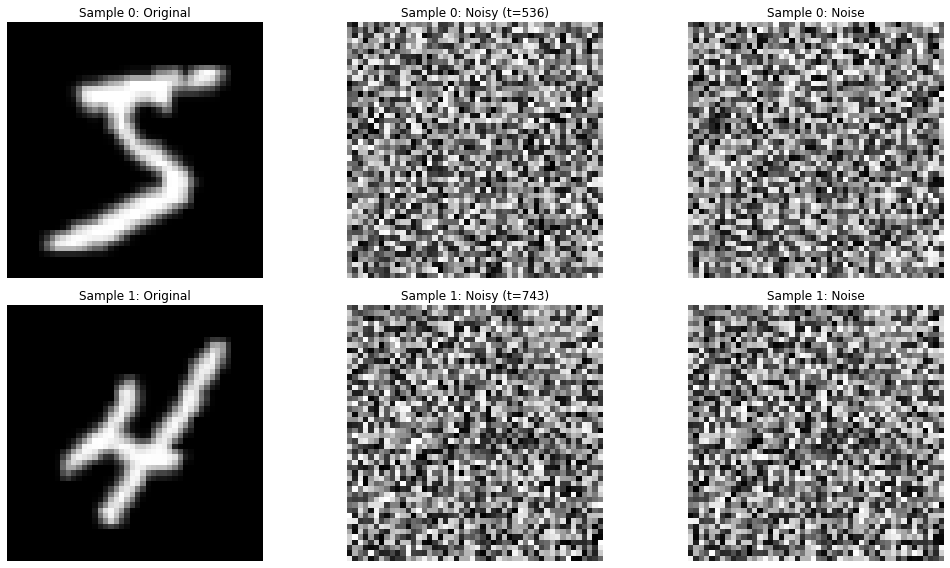

In [4]:
# diffusion betas and alphas
betas = torch.linspace(start=0.0001, end=0.02, steps=timestep)  
alpha = 1 - betas
alphaCumProduct = torch.cumprod(alpha, dim=0)
alphasCumprodPrev = torch.cat((torch.tensor([1.0]), alphaCumProduct[:-1]), dim=-1) 
variance = (1-alpha)*(1-alphasCumprodPrev)/(1-alphaCumProduct)  

def ForwardDiffusion(batchX, batchT):
    batchNoiseT = torch.randn_like(batchX)
    # reshape
    batchAlphaCumProduct = alphaCumProduct.to(device)[batchT].view(batchX.shape[0], 1, 1, 1)
    batchXT = torch.sqrt(batchAlphaCumProduct) * batchX + torch.sqrt(1 - batchAlphaCumProduct) * batchNoiseT
    return batchXT, batchNoiseT

if __name__ == "__main__":
    # [2, 1, 48, 48]
    batchX = torch.stack((trainDataset[0][0], trainDataset[9][0]), dim=0).to(device)

    # Image before noise
    inputImage0 = tensorToPil(batchX[0])
    inputImage1 = tensorToPil(batchX[1])
    inputImage0.save("inputImage0.jpg")
    inputImage1.save("inputImage1.jpg")

    # Transform the pixels from the range [0,1] to [-1,1] to match Gaussian Distribution
    batchX = batchX * 2 - 1
    batchT = torch.randint(0, timestep, size=(batchX.shape[0],)).to(device)
    print('batchT:', batchT)

    batchXT, batchNoiseT = ForwardDiffusion(batchX, batchT)
    print('batchXT:', batchXT.size())
    print('batchNoiseT:', batchNoiseT.size())

    # Save images
    outputImage0 = tensorToPil((batchXT[0] + 1) / 2)
    outputImage1 = tensorToPil((batchXT[1] + 1) / 2)  
    noiseImage0 = tensorToPil((batchNoiseT[0] + 1) / 2)
    noiseImage1 = tensorToPil((batchNoiseT[1] + 1) / 2) 
    
    outputImage0.save("outputImage0.jpg")
    outputImage1.save("outputImage1.jpg")
    noiseImage0.save("noiseImage0.jpg")
    noiseImage1.save("noiseImage1.jpg")
    
    # Plot images with Matplotlib
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Sample 0
    imagesSample0 = [inputImage0, outputImage0, noiseImage0]
    titlesSample0 = ['Original', f'Noisy (t={batchT[0].item()})', 'Noise']
    
    for i, (img, title) in enumerate(zip(imagesSample0, titlesSample0)):
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Sample 0: {title}')
        axes[0, i].axis('off')
    
    # Sample 1 
    imagesSample1 = [inputImage1, outputImage1, noiseImage1]
    titlesSample1 = ['Original', f'Noisy (t={batchT[1].item()})', 'Noise']
    
    for i, (img, title) in enumerate(zip(imagesSample1, titlesSample1)):
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'Sample 1: {title}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig("diffusion_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

In [5]:
#Frequency Embeddings
class TimePositionEmbedding(nn.Module):
    def __init__(self, embeddingSize):
        super(TimePositionEmbedding, self).__init__()
        self.halfembeddingSize = embeddingSize // 2

        #Create frequency basis like [e**(0*(-1*log(10000)/3)), e**(1*(-1*log(10000)/3)), e**(2*(-1*log(10000)/3)), e**(3*(-1*log(10000)/3))]
        halfEmbedding = torch.exp(torch.arange(self.halfembeddingSize) * (-1 * math.log(10000) / (self.halfembeddingSize -1))).to(device)
        #We use register buffer to tell pytorch not to store gradients here
        self.register_buffer("halfEmbedding", halfEmbedding)

    def forward(self, timestep):
        timestep = timestep.view(timestep.shape[0], 1)  # [b] -> [b, 1]

        # self.halfEmbedding: [self.halfembeddingSize]
        # unsqueeze -> [1, self.halfembeddingSize]
        # expand -> [b, self.halfembeddingSize]
        halfEmbedding = self.halfEmbedding.unsqueeze(0).expand(timestep.shape[0], self.halfembeddingSize)

        # [b, self.halfembeddingSize] * [b, 1] = [b, self.halfembeddingSize]
        halfEmbeddingTimestep = halfEmbedding.to(device) * timestep.to(device)

        # [b, self.halfembeddingSize * 2] = [b, embeddingSize]
        embeddingTimestep = torch.cat((halfEmbeddingTimestep.sin(), halfEmbeddingTimestep.cos()), dim = -1)
        return embeddingTimestep

if __name__ == "__main__":
    timePositionEmbedding = TimePositionEmbedding(embeddingSize=10)
    t = torch.randint(low = 0, high = 1000, size = (2,)).to(device) 
    print(t)
    embeddingT = timePositionEmbedding(t)
    print(embeddingT)

tensor([881, 882])
tensor([[ 0.9766,  0.1350,  0.5768,  0.7714,  0.0880,  0.2150,  0.9908, -0.8169,
          0.6364,  0.9961],
        [ 0.7086,  0.2332,  0.5686,  0.7720,  0.0881, -0.7056,  0.9724, -0.8226,
          0.6356,  0.9961]])


In [6]:
# MultiheadSelf Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embeddingSize, numberOfHeads, qkvBias = True):
        super(MultiHeadSelfAttention, self).__init__()

        self.numberOfHeads = numberOfHeads
        self.headEmbeddingSize = embeddingSize // numberOfHeads
        assert self.headEmbeddingSize * numberOfHeads == embeddingSize, \
            "embeddingSize should be divisible by numberOfHeads"

        self.w_q = nn.Linear(embeddingSize, embeddingSize, bias = qkvBias)
        self.w_k = nn.Linear(embeddingSize, embeddingSize, bias = qkvBias)
        self.w_v = nn.Linear(embeddingSize, embeddingSize, bias = qkvBias)

    def forward(self, hiddenStates):
        # linear
        query = self.w_q(hiddenStates)
        key = self.w_k(hiddenStates)
        value = self.w_v(hiddenStates)

        # view
        query = query.view(query.shape[0], query.shape[1], self.numberOfHeads, self.headEmbeddingSize).permute(0,2,1,3).contiguous()
        key = key.view(key.shape[0], key.shape[1], self.numberOfHeads, self.headEmbeddingSize).permute(0,2,1,3).contiguous()
        value = value.view(value.shape[0], value.shape[1], self.numberOfHeads, self.headEmbeddingSize).permute(0,2,1,3).contiguous()

        # attentionScores
        attentionScores = torch.matmul(query, key.transpose(-1,-2)) * query.shape[-1] ** -0.5
        attentionScores = F.softmax(attentionScores, dim = -1)

        attentionOutput = torch.matmul(attentionScores, value)

        # return to original size
        attentionOutput = attentionOutput.view(attentionOutput.shape[0], attentionOutput.shape[2], -1)
        return attentionOutput
    
def modulate(x, shift, scale):
    r"""
    Perform dit block shift and scale
    Args:
        x:      torch.tensor, [b, L, c]
        shift:  torch.tensor, [b, c]
        scale:  torch.tensor, [b, c]
    Return:
        torch.tensor, [b, L, c]
    """
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

In [7]:
class DitBlock(nn.Module):
    def __init__(self, embeddingSize, numberOfHeads, mlpRatio = 4):
        super(DitBlock, self).__init__()
        
        self.norm1 = nn.LayerNorm(embeddingSize, eps = 1e-6)
        self.attn = MultiHeadSelfAttention(embeddingSize, numberOfHeads)
        self.norm2 = nn.LayerNorm(embeddingSize, eps = 1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(embeddingSize, embeddingSize * mlpRatio, bias = True),
            nn.SiLU(),
            nn.Linear(embeddingSize * mlpRatio, embeddingSize, bias = True)
        )
        self.adaLN = nn.Sequential(
            nn.SiLU(),
            nn.Linear(embeddingSize, embeddingSize * 6, bias = True)
        )

    def forward(self, hiddenStates, condition):
        x = hiddenStates
        condition = self.adaLN(condition)
        alpha1, alpha2, beta1, beta2, gamma1, gamma2 = torch.chunk(condition, chunks = 6, dim = 1) # [b, embeddingSize]
        # Layer Norm 1
        hiddenStates = self.norm1(hiddenStates)  # [B, L, embeddingSize]
        # Scale and shift
        hiddenStates = modulate(hiddenStates, beta1, gamma1)  # [B, L, embeddingSize]
        # Multi-head-self-attention
        hiddenStates = self.attn(hiddenStates)
        # Scale with alpha1
        hiddenStates = hiddenStates * alpha1.unsqueeze(1)
        # Residual block
        hiddenStates = x + hiddenStates
        x1 = hiddenStates
        # Layer Norm 2
        hiddenStates = self.norm2(hiddenStates)
        # Scale and shift
        hiddenStates = modulate(hiddenStates, beta2, gamma2)
        # MLP (Pointwise FeedForward) 
        hiddenStates = self.mlp(hiddenStates)
        # Scale
        hiddenStates = hiddenStates * alpha2.unsqueeze(1)
        # Residual block
        hiddenStates = hiddenStates + x1
        return hiddenStates


if __name__ == "__main__":
    ditBlock = DitBlock(128, 4)
    hiddenStates = torch.randn([2, 10, 128])
    condition = torch.randn([2, 128])
    out = ditBlock(hiddenStates, condition)
    print(out.shape)

torch.Size([2, 10, 128])


In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, patchSize, numberOfChannels, hiddenStates):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Conv2d(in_channels = numberOfChannels, out_channels = hiddenStates, kernel_size = patchSize, stride = patchSize)

    def forward(self, hiddenStates):
        hiddenStates = self.projection(hiddenStates)  # [b, output_channel, patchSize, patchSize]
        hiddenStates = hiddenStates.flatten(2).transpose(1,2) # [b, patchCount*patchCount, output_channel]
        return hiddenStates


class Dit(nn.Module):
    def __init__(self, imageSize, patchSize, inputChannel, embeddingSize, ditBlockNumber, numberOfHeads, labelNumber, mlpRatio = 4):
        super(Dit, self).__init__()
        self.patchSize = patchSize
        self.embeddingSize = embeddingSize
        self.channels = inputChannel
        # Note: patchSize cannot be divisible by imageSize
        self.numberOfPatches = (imageSize // patchSize) ** 2
        self.patchCount = imageSize // self.patchSize
        # patchEmbedding
        self.patchEmbedding = PatchEmbedding(patchSize = patchSize, numberOfChannels = inputChannel, hiddenStates = embeddingSize)
        self.positionEmbedding = nn.Parameter(torch.randn([1, self.numberOfPatches, embeddingSize]).to(device))
        # timeEmbedding
        self.timeEmbedding = nn.Sequential(
            TimePositionEmbedding(embeddingSize),
            nn.Linear(embeddingSize, embeddingSize),
            nn.ReLU(),
            nn.Linear(embeddingSize, embeddingSize)
        )
        # cls_embedding
        self.cls_embedding = nn.Embedding(num_embeddings = labelNumber, embedding_dim = embeddingSize)
        # dit_block
        self.ditBlocks = nn.ModuleList()
        for _ in range(ditBlockNumber):
            self.ditBlocks.append(DitBlock(embeddingSize, numberOfHeads, mlpRatio))
        # layer norm
        self.norm = nn.LayerNorm(embeddingSize)
        # linear back to patch
        self.linear = nn.Linear(embeddingSize, inputChannel * patchSize ** 2)

    def unpatchify(self, batchX):
        r"""
        Perform diffusion transformer unpatchify
        """
        batchX = batchX.reshape(batchX.shape[0], self.patchCount, self.patchCount, self.channels, self.patchSize, self.patchSize)
        batchX = torch.permute(batchX, dims=[0,3,1,2,4,5]).contiguous()  # [b,c,patchCount,patchCount,patchSize,patchSize]
        batchX = torch.permute(batchX, dims=[0,1,2,4,3,5]).contiguous()  # [b,c,patchCount,patchSize,patchCount,patchSize]
        batchX = torch.reshape(batchX, shape = [batchX.shape[0], batchX.shape[1], batchX.shape[2]*batchX.shape[3], batchX.shape[4]*batchX.shape[5]])
        return batchX

    def forward(self, batchX, batchT, batch_cls):
        r"""
        Perform diffusion transformer forward
        """
        batchX = batchX.to(device)
        batchT = batchT.to(device)
        batch_cls = batch_cls.to(device)

        # cls_embedding
        batch_cls = self.cls_embedding(batch_cls)
        # timeEmbedding
        batchT = self.timeEmbedding(batchT)
        # timeEmbedding + cls_embedding
        embedding = batchT + batch_cls
        # patchify and add position embedding
        batchX = self.patchEmbedding(batchX)
        batchX = batchX + self.positionEmbedding  # [b, patchCount*patchCount, embeddingSize]
        # dit block
        for layer in self.ditBlocks:
            batchX = layer(batchX, embedding)      #  [b, patchCount*patchCount, embeddingSize]
        # layer norm
        batchX = self.norm(batchX)  # [b, patchCount*patchCount, embeddingSize]
        # linear
        batchX = self.linear(batchX)  # [b, patchCount*patchCount, inputChannel*patchSize**2]
        # unpatchify
        batchX = self.unpatchify(batchX)  # [b, c, h, w]
        return batchX


if __name__ == "__main__":
    # init
    ditTransformer = Dit(imageSize = 48, patchSize = 4, inputChannel = 1, embeddingSize = 128, ditBlockNumber = 4, numberOfHeads = 4, labelNumber = 10, mlpRatio = 4)
    ditTransformer = ditTransformer.to(device)

    x=torch.rand(2,1,48,48).to(device)
    t=torch.randint(0,timestep,(2,)).to(device)
    y=torch.randint(0,10,(2,)).to(device)

    out = ditTransformer(x, t, y)

    print(out.shape)

torch.Size([2, 1, 48, 48])


In [9]:
#Forward Pass

#Data loader uses 0 workers on CPU to avoid extra RAM
mnistDataLoader = DataLoader(dataset=trainDataset,batch_size=batchSize,shuffle=True,num_workers=0    )

#Initialize Model
model = Dit(
    imageSize=48,
    patchSize=4,
    inputChannel=1,
    embeddingSize=128,
    ditBlockNumber=4,
    numberOfHeads=4,
    labelNumber=10,
    mlpRatio=4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunction = nn.L1Loss()

def TrainSingleEpoch(model, dataloader, optimizer, lossFunction, epoch, device, writer):
    model.train()
    epochLoss = 0.0

    for step, (batchX, batchCLS) in enumerate(dataloader):
        # Print batch info every 10 steps
        if step % 10 == 0:
            print(f"[Epoch {epoch}] Step {step}/{len(dataloader)}...")

        batchX = batchX.to(device) * 2 - 1
        batchT = torch.randint(low=0, high=timestep, size=(batchX.shape[0],)).to(device)
        batchCLS = batchCLS.to(device)

        # Forward diffusion
        batchXT, batchNoiseT = ForwardDiffusion(batchX, batchT)

        # Prediction
        batchPredictT = model(batchXT, batchT, batchCLS)

        # Loss calculation
        loss = lossFunction(batchPredictT, batchNoiseT)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epochLoss += loss.item()

        # Log and print intermediate loss
        if step % 10 == 0:
            print(f"  → Loss: {loss.item():.4f}")
            writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + step)

    averageLoss = epochLoss / len(dataloader)
    print(f"[Epoch {epoch}] Average Loss = {averageLoss:.4f}")

    return averageLoss



if __name__ == "__main__":
    # Create output folders
    os.makedirs('models', exist_ok=True)
    os.makedirs('logs', exist_ok=True)

    writer = SummaryWriter(log_dir='logs')

    for epoch in range(maxEpoch):
        print(f"=== Start training at epoch {epoch} ===")
        averageLoss = TrainSingleEpoch(model, mnistDataLoader, optimizer, lossFunction, epoch, device, writer)
        print(f"=== End epoch {epoch}, Average Loss = {averageLoss:.4f} ===")

        # Save model periodically
        if epoch % 1 == 0:
            modelSavePath = os.path.join('models', f"model_epoch_{epoch}.pt")
            torch.save(model.state_dict(), modelSavePath)
            print(f"Model saved to {modelSavePath}")

    writer.close()
    print("Training complete.")


=== Start training at epoch 0 ===
[Epoch 0] Step 0/300...


KeyboardInterrupt: 

Using device: cpu
Loading model...
Model loaded successfully!
\nGenerating samples for class 0...
Generated samples saved to generated_class_0.png


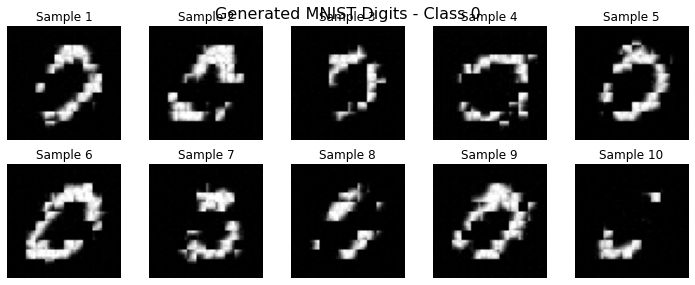

Diffusion process visualization saved to diffusion_process_class_0.png


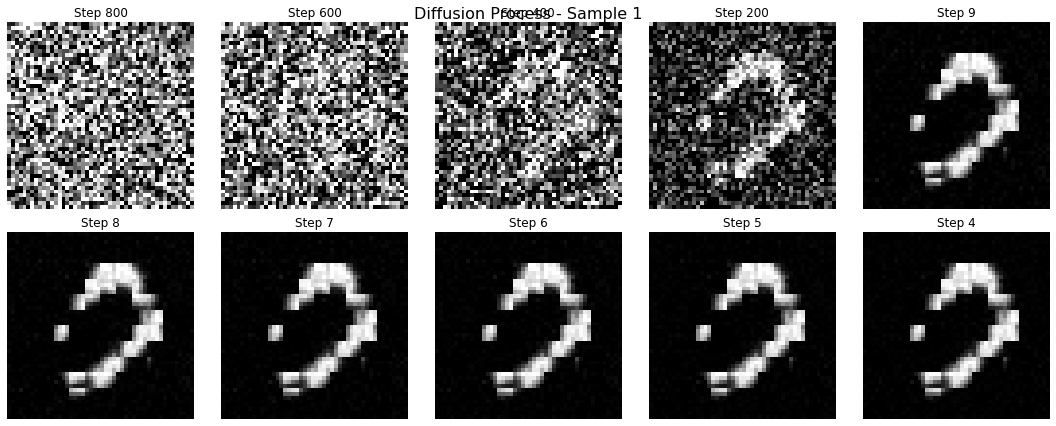

\nGenerating samples for class 1...
Generated samples saved to generated_class_1.png


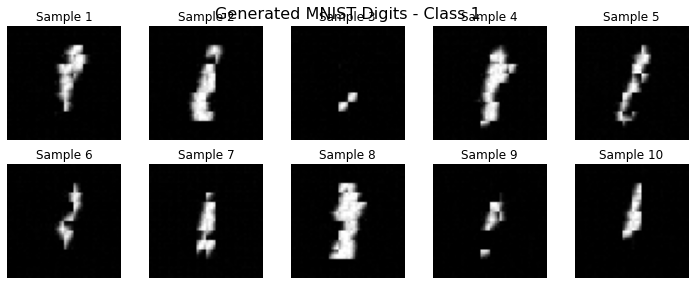

Diffusion process visualization saved to diffusion_process_class_1.png


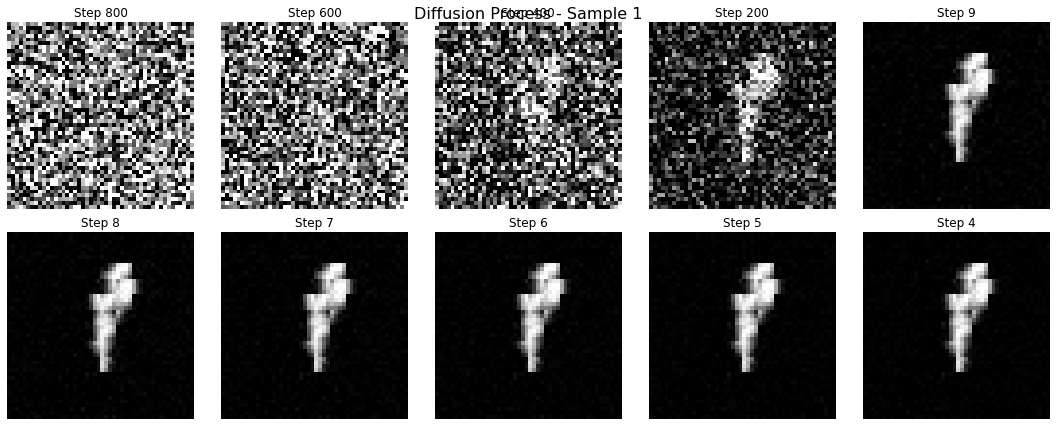

\nGenerating samples for class 2...
Generated samples saved to generated_class_2.png


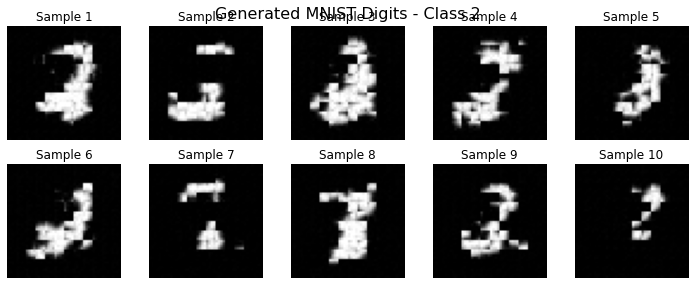

Diffusion process visualization saved to diffusion_process_class_2.png


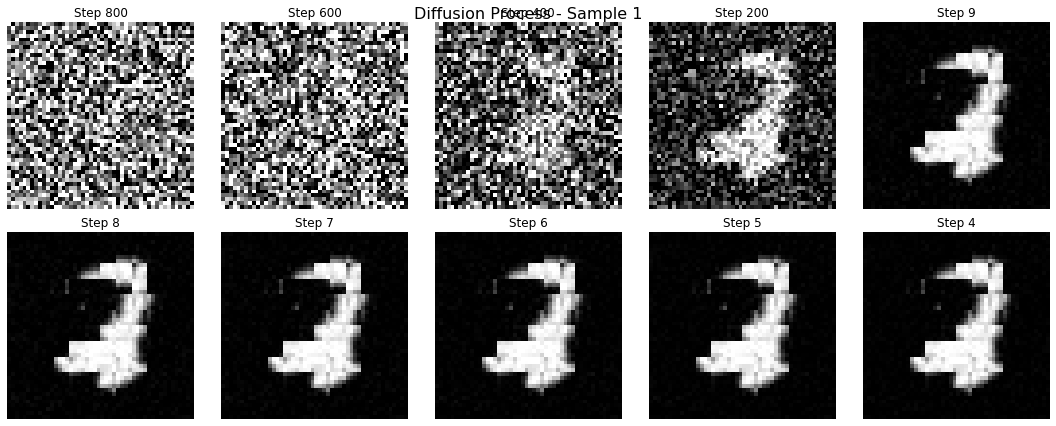

\nGenerating samples for class 3...
Generated samples saved to generated_class_3.png


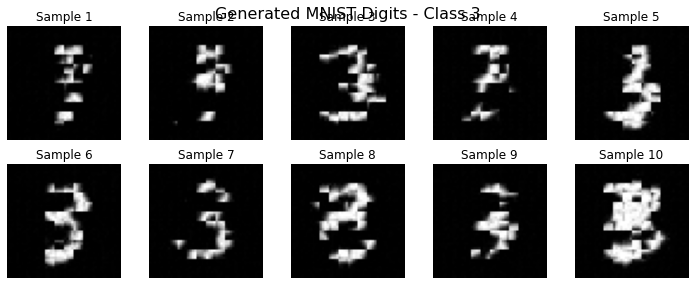

Diffusion process visualization saved to diffusion_process_class_3.png


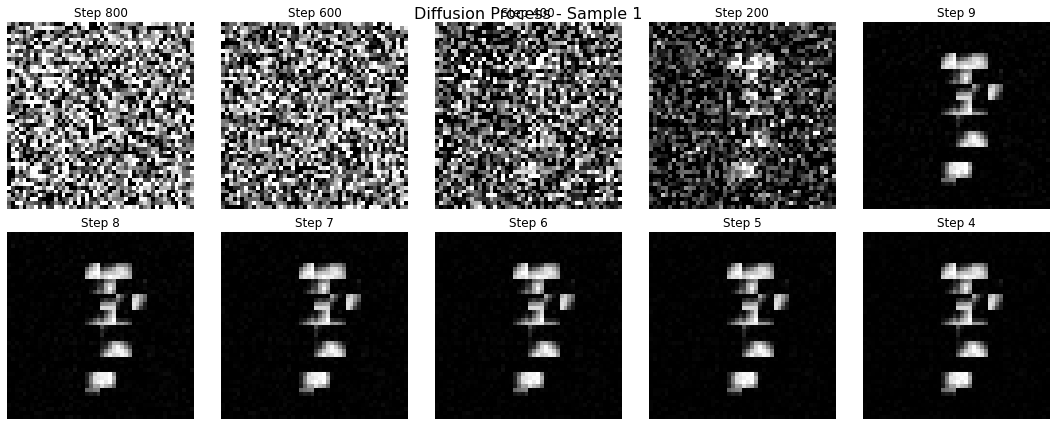

\nGenerating samples for class 4...
Generated samples saved to generated_class_4.png


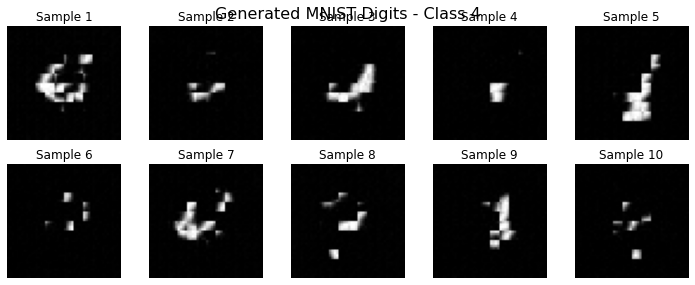

Diffusion process visualization saved to diffusion_process_class_4.png


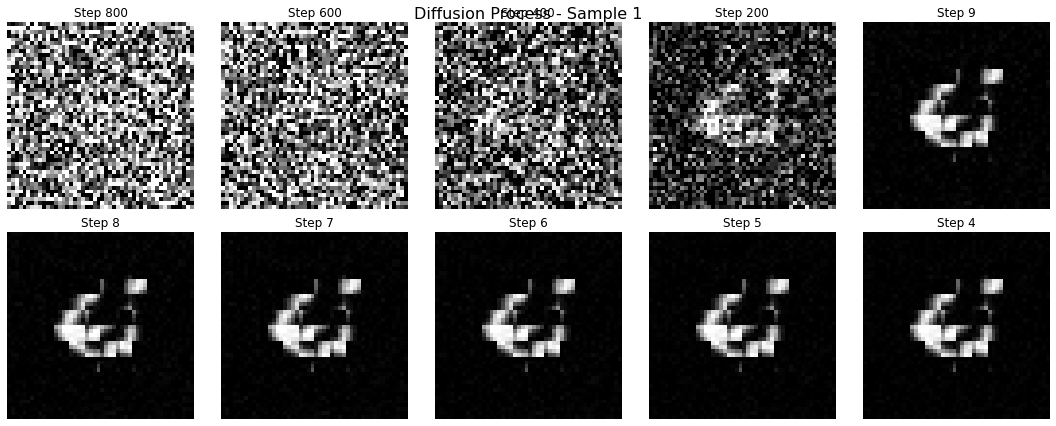

In [13]:
# Load the model and components
def LoadModelInference(modelPath, device):
    """Load a trained DiT model for inference"""
    model = Dit(
    imageSize=48,
    patchSize=4,
    inputChannel=1,
    embeddingSize=128,
    ditBlockNumber=4,
    numberOfHeads=4,
    labelNumber=10,
    mlpRatio=4
    ).to(device)
    
    model.load_state_dict(torch.load(modelPath, map_location=device))
    model.eval()
    return model

def ReverseDiffusion(model, numberOfSamples=10, classLabel=5, device="cpu"):
    """
    Perform reverse diffusion process to generate new samples
    
    Args:
        model: Trained DiT model
        numberOfSamples: Number of samples to generate
        classLabel: Class label to generate (0-9 for MNIST)
        device: Device to run inference on
    """
    # Start from random noise
    x_t = torch.randn(numberOfSamples, 1, 48, 48).to(device)
    
    # Class labels (all the same class)
    classLabels = torch.full((numberOfSamples,), classLabel, dtype=torch.long).to(device)
    
    # Store intermediate results for visualization
    intermediate_results = []
    
    # Reverse diffusion process
    with torch.no_grad():
        for t in range(timestep-1, -1, -1):
            # Create timestep tensor
            timesteps = torch.full((numberOfSamples,), t, dtype=torch.long).to(device)
            
            # Predict noise
            predicted_noise = model(x_t, timesteps, classLabels)
            
            # Get alpha and beta values for this timestep
            alpha_t = alpha[t].to(device)
            alpha_cumprod_t = alphaCumProduct[t].to(device)
            alpha_cumprod_prev_t = alphasCumprodPrev[t].to(device) if t > 0 else torch.tensor(1.0).to(device)
            
            # Calculate coefficients for reverse process
            beta_t = betas[t].to(device)
            variance_t = variance[t].to(device)
            
            # Predict x0 from xt
            pred_x0 = (x_t - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_cumprod_t)
            pred_x0 = torch.clamp(pred_x0, -1.0, 1.0)
            
            # Calculate mean and variance for reverse process
            mean = (torch.sqrt(alpha_cumprod_prev_t) * beta_t * pred_x0 + 
                   torch.sqrt(alpha_t) * (1 - alpha_cumprod_prev_t) * x_t) / (1 - alpha_cumprod_t)
            
            # Add noise if not the last step
            if t > 0:
                noise = torch.randn_like(x_t)
                x_t = mean + torch.sqrt(variance_t) * noise
            else:
                x_t = mean
            
            # Store some intermediate steps for visualization
            if t % 200 == 0 or t < 10:
                intermediate_results.append((t, x_t.detach().cpu()))
    
    return x_t.detach().cpu(), intermediate_results

def tensor_to_pil(tensor):
    """Convert tensor to PIL Image"""
    tensor = (tensor + 1) / 2  # Scale from [-1, 1] to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    
    if len(tensor.shape) == 4:
        tensor = tensor.squeeze(1)  # Remove channel dimension for grayscale
    
    # Convert to numpy and scale to 0-255
    numpy_array = (tensor.numpy() * 255).astype(np.uint8)
    
    # Create PIL images
    pil_images = []
    for i in range(numpy_array.shape[0]):
        pil_img = Image.fromarray(numpy_array[i], mode='L')
        pil_images.append(pil_img)
    
    return pil_images

def VisualizeGeneratedSamples(samples, classLabel, save_path=None):
    """Visualize generated samples"""
    numberOfSamples = len(samples)
    
    # Calculate grid dimensions
    cols = min(5, numberOfSamples)
    rows = (numberOfSamples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, (sample_tensor, pil_img) in enumerate(samples):
        if i < len(axes):
            axes[i].imshow(pil_img, cmap='gray')
            axes[i].set_title(f'Sample {i+1}')
            axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(len(samples), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Generated MNIST Digits - Class {classLabel}', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Generated samples saved to {save_path}")
    
    plt.show()

def VisualizeDiffusionProcess(intermediate_results, sample_idx=0, save_path=None):
    """Visualize the diffusion process for one sample"""
    stepsToShow = min(10, len(intermediate_results))
    selectedSteps = [intermediate_results[i] for i in range(0, len(intermediate_results), len(intermediate_results)//stepsToShow)][:stepsToShow]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for idx, (t, x_t) in enumerate(selectedSteps):
        if idx < len(axes):
            # Get the specific sample
            sample = x_t[sample_idx].unsqueeze(0)
            pil_images = tensor_to_pil(sample)
            
            axes[idx].imshow(pil_images[0], cmap='gray')
            axes[idx].set_title(f'Step {t}')
            axes[idx].axis('off')
    
    plt.suptitle(f'Diffusion Process - Sample {sample_idx+1}', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Diffusion process visualization saved to {save_path}")
    
    plt.show()

# Main inference function
def main():
    # Set device
    device = "cuda:1" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Model path (update this to your actual model path)
    modelPath = "models/model_epoch_9.pt"  # Update with your actual model path
    
    if not os.path.exists(modelPath):
        print(f"Model not found at {modelPath}")
        print("Please update the modelPath variable to point to your trained model.")
        return
    
    # Load model
    print("Loading model...")
    model = LoadModelInference(modelPath, device)
    print("Model loaded successfully!")
    
    # Generate samples for different classes
    classes_to_generate = [0, 1, 2, 3, 4]  # Generate digits 0-4
    
    for classLabel in classes_to_generate:
        print(f"\\nGenerating samples for class {classLabel}...")
        
        # Generate samples
        generated_tensors, intermediate_results = ReverseDiffusion(
            model, 
            numberOfSamples=10, 
            classLabel=classLabel, 
            device=device
        )
        
        # Convert to PIL images
        pil_images = tensor_to_pil(generated_tensors)
        
        # Create samples list for visualization
        samples = list(zip(generated_tensors, pil_images))
        
        # Visualize generated samples
        VisualizeGeneratedSamples(
            samples, 
            classLabel,
            save_path=f"generated_class_{classLabel}.png"
        )
        
        # Visualize diffusion process for first sample
        VisualizeDiffusionProcess(
            intermediate_results,
            sample_idx=0,
            save_path=f"diffusion_process_class_{classLabel}.png"
        )
        
        # Save individual generated images
        os.makedirs(f"generated_samples/class_{classLabel}", exist_ok=True)
        for i, pil_img in enumerate(pil_images):
            pil_img.save(f"generated_samples/class_{classLabel}/sample_{i+1}.png")

if __name__ == "__main__":
    main()